In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import nengo_dl
import nengo
import nengo_loihi
import random

In [2]:
print(tf.__version__, nengo_dl.__version__, nengo.__version__, nengo_loihi.__version__) # => 2.2.0 3.4.0 3.1.0, 1.0.0
random.seed(0)

2.2.0 3.4.0 3.1.0 1.0.0


## Training and Evaluating TF network

In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
tf.random.set_seed(0)

In [4]:
# input
inp = tf.keras.Input(shape=(28, 28, 1))

# convolutional layers
conv0 = tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=3,
    activation=tf.nn.relu,
)(inp)

max_pool = tf.keras.layers.MaxPool2D()(conv0)

conv1 = tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=3,
    strides=2,
    activation=tf.nn.relu,
)(max_pool)

# fully connected layer
flatten = tf.keras.layers.Flatten()(conv1)
dense = tf.keras.layers.Dense(units=10, activation="softmax")(flatten)

model = tf.keras.Model(inputs=inp, outputs=dense)

In [5]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                23050     
Total params: 41,866
Trainable params: 41,866
Non-trainable params: 0
_________________________________________________________

In [6]:
model.compile(
  optimizer=tf.optimizers.Adam(0.001),
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=[tf.metrics.sparse_categorical_accuracy])
model.fit(train_images, train_labels, epochs=4)

Epoch 1/4
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2801 - sparse_categorical_accuracy: 0.9439
Epoch 2/4
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0742 - sparse_categorical_accuracy: 0.9776
Epoch 3/4
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0572 - sparse_categorical_accuracy: 0.9828
Epoch 4/4
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0508 - sparse_categorical_accuracy: 0.9844


In [7]:
model.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 4ms/step - loss: 0.0779 - sparse_categorical_accuracy: 0.9800


[0.07794930785894394, 0.9800000190734863]

## Converting to NengoDL Network

In [8]:
n_steps, sfr = 40, 100 # Simulation Timesteps and Scale Firing Rates parameter.

np.random.seed(0)
ndl_model = nengo_dl.Converter(
  model,
  swap_activations={tf.nn.relu: nengo.SpikingRectifiedLinear()},
  scale_firing_rates=sfr,
  synapse=0.005,
)

with ndl_model.net:
  nengo_dl.configure_settings(stateful=False)
  
  # Probe Conv0 layer.
  # Probing ndl_model.layers[conv0].ensemble.neurons is same as Probing ndl_model.layers[conv0]
  conv0_lyr_otpt = nengo.Probe(ndl_model.layers[conv0].ensemble.neurons, attr="output", synapse=None)
  conv0_lyr_syn_otpt = nengo.Probe(ndl_model.layers[conv0].ensemble.neurons, attr="output", synapse=0.005)

/home/rgaurav/miniconda3/envs/latest-nengo-tf/lib/python3.7/site-packages/nengo_dl/converter.py:326: UserWarning: Cannot convert max pooling layers to native Nengo objects; consider setting max_to_avg_pool=True to use average pooling instead. Falling back to TensorNode.
  % (error_msg + ". " if error_msg else "")
/home/rgaurav/miniconda3/envs/latest-nengo-tf/lib/python3.7/site-packages/nengo_dl/converter.py:588: UserWarning: Activation type <function softmax at 0x2adada7e4170> does not have a native Nengo equivalent; falling back to a TensorNode
  "falling back to a TensorNode" % activation


In [9]:
ndl_test_images = np.tile(
  test_images.reshape((test_images.shape[0], 1, -1)), (1, n_steps, 1))
ndl_input = ndl_model.inputs[inp]
ndl_output = ndl_model.outputs[dense]

In [10]:
with nengo_dl.Simulator(
  ndl_model.net, minibatch_size=100) as ndl_sim:
  data1 = ndl_sim.predict({ndl_input: ndl_test_images[:200]})

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               


### Accuracy over first 200 test images

In [11]:
acc = 0
for pred, true in zip(data1[ndl_output][:, -1, :], test_labels):
  if np.argmax(pred) == true:
    acc += 1
print(acc/200)

0.99


### Investigating raw output from Conv0 layer before multiplying with `sfr` and `dt`.

In [12]:
conv0_otpt = data1[conv0_lyr_otpt]
conv0_otpt.shape

(200, 40, 21632)

Above probed output of the first Conv layer shows that the matrix `conv0_otpt` contains spike related data of first `200` images, for `40` simulation timesteps of `21632` neurons.

For a chosen test image say at index 0, not all the neurons in Conv0 layer would have spiked. Therefore choose the neurons which have spiked at least once (in any timestep) for test image at index 0.

In [13]:
test_image_index, spiked_neurons_index = 0, []
for neuron in range(conv0_otpt.shape[-1]):
  if np.any(conv0_otpt[test_image_index, :, neuron]):
    spiked_neurons_index.append(neuron)

For the chosen **Target** image at `test_image_index=0`, check which neurons have spiked, and choose a random number of those spiked neurons and calculate their firing rates for plotting them.

In [14]:
print("Neuron which spiked (in any timestep) for test image of digit %s are: %s" 
       %(test_labels[test_image_index], spiked_neurons_index))
# Choose 100 random neurons.
np.random.seed(0)
random_neurons_which_spiked = np.random.choice(spiked_neurons_index, 100)
print(random_neurons_which_spiked)

Neuron which spiked (in any timestep) for test image of digit 7 are: [12, 44, 45, 53, 60, 76, 85, 97, 108, 109, 111, 143, 149, 161, 172, 173, 204, 205, 268, 271, 301, 335, 348, 353, 364, 365, 428, 460, 463, 481, 495, 545, 559, 588, 620, 652, 655, 684, 716, 719, 725, 737, 748, 780, 783, 813, 815, 821, 844, 860, 876, 879, 908, 917, 940, 943, 961, 975, 1005, 1007, 1037, 1039, 1068, 1100, 1101, 1132, 1165, 1167, 1173, 1196, 1229, 1237, 1263, 1292, 1293, 1295, 1301, 1324, 1325, 1327, 1345, 1356, 1359, 1365, 1388, 1397, 1420, 1421, 1429, 1441, 1452, 1455, 1484, 1487, 1519, 1532, 1551, 1580, 1615, 1645, 1647, 1653, 1692, 1708, 1740, 1772, 1775, 1805, 1820, 1825, 1836, 1845, 1868, 1871, 1877, 1884, 1901, 1903, 1932, 1935, 1964, 1980, 2005, 2012, 2028, 2031, 2076, 2092, 2093, 2095, 2124, 2127, 2156, 2188, 2220, 2223, 2252, 2255, 2284, 2305, 2319, 2332, 2380, 2383, 2401, 2412, 2444, 2453, 2476, 2479, 2485, 2508, 2541, 2604, 2607, 2625, 2636, 2637, 2639, 2645, 2652, 2668, 2671, 2677, 2684, 2700, 

### Get the Spikes from Conv0 layer after multiplying with `sfr` and `dt` and plot the firing rates

In [15]:
conv0_spikes_matrix = data1[conv0_lyr_otpt] * sfr * 0.001 # dt = 0.001

In [16]:
firing_rates = []
for neuron in random_neurons_which_spiked:
  # Calculate firing rates of the random neurons.
  firing_rates.append(np.sum(conv0_spikes_matrix[test_image_index, :, neuron])/(n_steps * 0.001))

### Plot the firing rates of those 100  random neurons

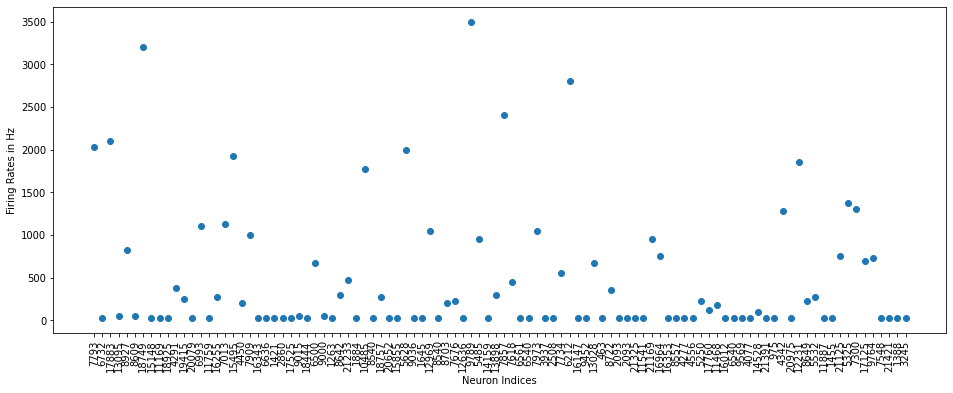

In [17]:
plt.figure(1, figsize=(16, 6))
plt.scatter([i for i in range(100)], firing_rates) # Plotting only for 100 random neurons.
plt.xticks([i for i in range(100)], random_neurons_which_spiked, rotation="vertical") # Plotting only for 100 random neurons.
plt.xlabel("Neuron Indices")
plt.ylabel("Firing Rates in Hz")
plt.show()

Above firing rates are of the 100 random neurons which spiked for the following image.

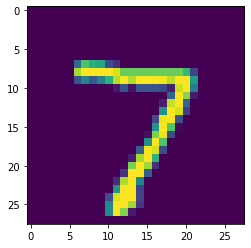

In [18]:
plt.imshow(test_images[test_image_index])

From the firing rate plot, from inspection I can see that few neurons spike at more than 1000Hz which ideally is not possible, a neuron can spike only once in a timestep, thus in 1000 timesteps, it can spike only for 1000 times => it's firing rate can be maximum at 1000Hz. But it doesn't happen here. Upon printing the related spikes for these neuron, you will see that it spikes more than once in a timestep, i.e. its spike amplitude is more than 1. Set the index of such a neuron in place of <set_index_here>.

In [19]:
firing_rates[<set_index_here>], conv0_spikes_matrix[test_image_index, :, random_neurons_which_spiked[<set_index_here>]]

SyntaxError: invalid syntax (<ipython-input-19-19eaf2aeadfa>, line 1)